In [3]:
!pip install tensorflowjs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflowjs as tfjs

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


TensorFlow version: 2.18.0
Keras version: 3.8.0


In [4]:
def create_sample_dataset():
    """Create sample dataset based on provided structure"""
    data = [
        ['user001', 'Wisata Alam Datuk', 5],
        ['user001', 'WISATA ALAM KASIH', 3],
        ['user001', 'Taman Wisata Alam Sibolangit', 3],
        ['user001', 'Wisata Alam Sikabung-kabung', 2],
        ['user001', 'Bukit Indah Simarjarunjung', 1],
        ['user001', 'Bukit Sipisopiso', 2],
        ['user001', 'Air Terjun Sigura-Gura', 1],
        ['user001', 'Taman Alam Lumbini Berastagi', 4],
        ['user001', 'Wisata Batu Katak', 2],
        ['user001', 'Kawah Putih Dolok Tinggi Raja', 5],
        ['user001', 'Pemandian alam Bah Damanik', 1],
        ['user001', 'Wisata Sawah Pematang Johar', 5],
        ['user001', 'Air Terjun Sikulikap', 1],
        ['user001', 'TAMAN WISATA DANAU SIOMBAK MARELAN', 4],
        ['user001', 'Penatapan Simarjarunjung', 4],
        ['user001', 'The Waterfall - Taman Simalem Resort', 4],
        ['user001', 'Penatapen Doulu', 2]
    ]

    # Expand dataset with more users for better training
    expanded_data = []
    users = [f'user{str(i).zfill(3)}' for i in range(1, 101)]  # 100 users
    items = list(set([item[1] for item in data]))

    np.random.seed(42)
    for user in users:
        # Each user rates 5-15 random items
        n_ratings = np.random.randint(5, 16)
        user_items = np.random.choice(items, n_ratings, replace=False)
        for item in user_items:
            rating = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.15, 0.25, 0.3, 0.2])
            expanded_data.append([user, item, rating])

    return pd.DataFrame(expanded_data, columns=['user_id', 'item_id', 'rating'])

# Load or create dataset
try:
    df = pd.read_csv('/content/dummy_cf_dataset.csv')
    print("Dataset loaded from file")
except:
    df = create_sample_dataset()
    print("Sample dataset created")

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head(10))

Dataset loaded from file
Dataset shape: (23900, 3)

First few rows:
   user_id                        item_id  rating
0  user001              Wisata Alam Datuk       5
1  user001              WISATA ALAM KASIH       3
2  user001   Taman Wisata Alam Sibolangit       3
3  user001    Wisata Alam Sikabung-kabung       2
4  user001     Bukit Indah Simarjarunjung       1
5  user001               Bukit Sipisopiso       2
6  user001         Air Terjun Sigura-Gura       1
7  user001   Taman Alam Lumbini Berastagi       4
8  user001              Wisata Batu Katak       2
9  user001  Kawah Putih Dolok Tinggi Raja       5



EXPLORATORY DATA ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23900 entries, 0 to 23899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  23900 non-null  object
 1   item_id  23900 non-null  object
 2   rating   23900 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 560.3+ KB
None

Basic Statistics:
             rating
count  23900.000000
mean       3.020418
std        1.414924
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000

Missing values:
user_id    0
item_id    0
rating     0
dtype: int64

Unique users: 100
Unique items: 239
Total ratings: 23900


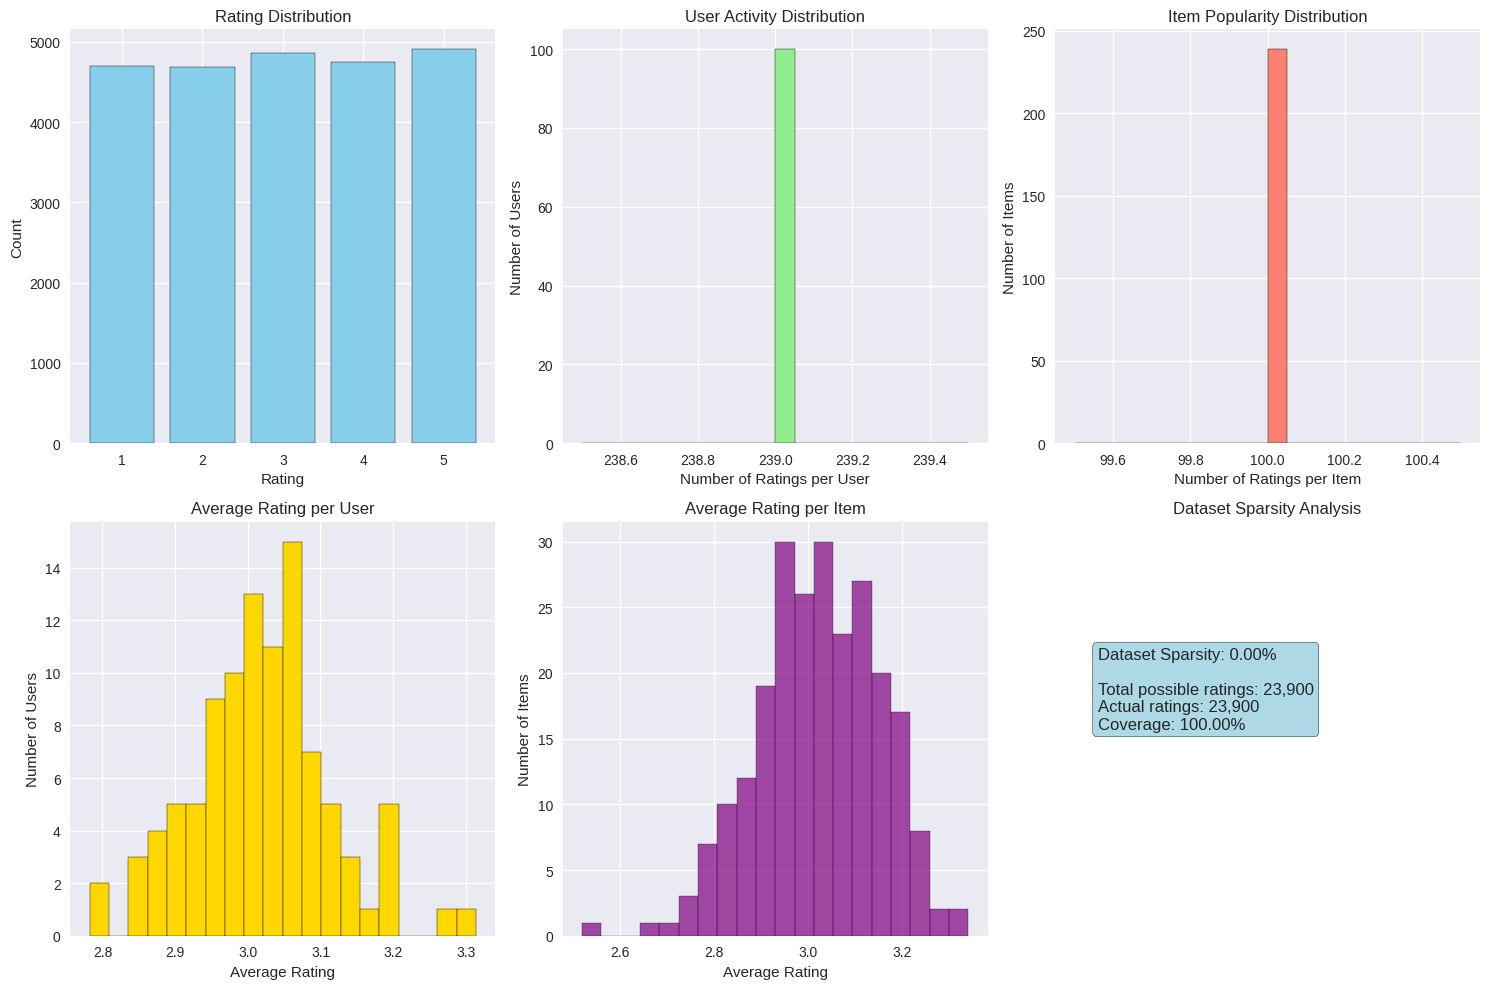


Top 10 Most Popular Items:
                                   Rating_Count  Avg_Rating
item_id                                                    
AIR TERJUN TURUNAN BUHIT (JABEL)            100        2.99
ALUN ALUN                                   100        3.11
Adipura Monument                            100        3.08
Aek Sijorni                                 100        3.01
Agrowisata Paloh Naga                       100        2.79
Air Terjun Aek Limut                        100        2.99
Air Terjun Efrata                           100        3.15
Air Terjun Janji                            100        3.03
Air Terjun Lau Lutih Tanjung Raja           100        3.11
Air Terjun Pelangi Indah                    100        2.95

Top 10 Most Active Users:
         Rating_Count  Avg_Rating
user_id                          
user001           239        2.97
user002           239        2.87
user003           239        3.03
user004           239        3.04
user005           239

In [5]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic statistics
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check unique values
print(f"\nUnique users: {df['user_id'].nunique()}")
print(f"Unique items: {df['item_id'].nunique()}")
print(f"Total ratings: {len(df)}")

# Rating distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# User activity distribution
plt.subplot(2, 3, 2)
user_activity = df.groupby('user_id').size()
plt.hist(user_activity, bins=20, color='lightgreen', edgecolor='black')
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')

# Item popularity distribution
plt.subplot(2, 3, 3)
item_popularity = df.groupby('item_id').size()
plt.hist(item_popularity, bins=20, color='salmon', edgecolor='black')
plt.title('Item Popularity Distribution')
plt.xlabel('Number of Ratings per Item')
plt.ylabel('Number of Items')

# Average rating per user
plt.subplot(2, 3, 4)
avg_rating_user = df.groupby('user_id')['rating'].mean()
plt.hist(avg_rating_user, bins=20, color='gold', edgecolor='black')
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')

# Average rating per item
plt.subplot(2, 3, 5)
avg_rating_item = df.groupby('item_id')['rating'].mean()
plt.hist(avg_rating_item, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.title('Average Rating per Item')
plt.xlabel('Average Rating')
plt.ylabel('Number of Items')

# Sparsity analysis
plt.subplot(2, 3, 6)
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)
sparsity = 1 - (n_ratings / (n_users * n_items))
plt.text(0.1, 0.5, f'Dataset Sparsity: {sparsity:.2%}\n\n'
                   f'Total possible ratings: {n_users * n_items:,}\n'
                   f'Actual ratings: {n_ratings:,}\n'
                   f'Coverage: {(1-sparsity):.2%}',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
plt.title('Dataset Sparsity Analysis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Top items and users
print(f"\nTop 10 Most Popular Items:")
top_items = df.groupby('item_id').agg({
    'rating': ['count', 'mean']
}).round(2)
top_items.columns = ['Rating_Count', 'Avg_Rating']
top_items = top_items.sort_values('Rating_Count', ascending=False)
print(top_items.head(10))

print(f"\nTop 10 Most Active Users:")
top_users = df.groupby('user_id').agg({
    'rating': ['count', 'mean']
}).round(2)
top_users.columns = ['Rating_Count', 'Avg_Rating']
top_users = top_users.sort_values('Rating_Count', ascending=False)
print(top_users.head(10))

In [6]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_encoded'] = user_encoder.fit_transform(df['user_id'])
df['item_encoded'] = item_encoder.fit_transform(df['item_id'])

# Create mappings for later use
user_to_encoded = dict(zip(df['user_id'], df['user_encoded']))
item_to_encoded = dict(zip(df['item_id'], df['item_encoded']))
encoded_to_user = dict(zip(df['user_encoded'], df['user_id']))
encoded_to_item = dict(zip(df['item_encoded'], df['item_id']))

n_users = df['user_encoded'].nunique()
n_items = df['item_encoded'].nunique()

print(f"Number of users after encoding: {n_users}")
print(f"Number of items after encoding: {n_items}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")

# Normalize ratings to 0-1 range for better training
min_rating = df['rating'].min()
max_rating = df['rating'].max()
df['rating_normalized'] = (df['rating'] - min_rating) / (max_rating - min_rating)

print(f"Normalized rating range: {df['rating_normalized'].min():.2f} - {df['rating_normalized'].max():.2f}")

# Split data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['rating'])

print(f"\nTrain set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


DATA PREPROCESSING
Number of users after encoding: 100
Number of items after encoding: 239
Rating range: 1 - 5
Normalized rating range: 0.00 - 1.00

Train set size: 15296
Validation set size: 3824
Test set size: 4780



MODEL BUILDING
Model Architecture:


Model: "CollaborativeFiltering"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 64)        │      6,400 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 64)        │     15,296 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 64)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (None, 64)        │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_concat          │ (None, 128)       │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense1 (Dense)  │ (None, 128)       │     16,512 │ mlp_concat[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dropout1        │ (None, 128)       │          0 │ mlp_dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense2 (Dense)  │ (None, 64)        │      8,256 │ mlp_dropout1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dropout2        │ (None, 64)        │          0 │ mlp_dense2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmf_multiply        │ (None, 64)        │          0 │ user_flatten[0][… │
│ (Multiply)          │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense3 (Dense)  │ (None, 32)        │      2,080 │ mlp_dropout2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_concat        │ (None, 96)        │          0 │ gmf_multiply[0][… │
│ (Concatenate)       │                   │            │ mlp_dense3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dense1        │ (None, 64)        │      6,208 │ final_concat[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 64)        │          0 │ final_dense1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dense2        │ (None, 32)        │      2,080 │ final_dropout[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ final_dense2[0][

 Total params: 56,865 (222.13 KB)

 Trainable params: 56,865 (222.13 KB)

 Non-trainable params: 0 (0.00 B)

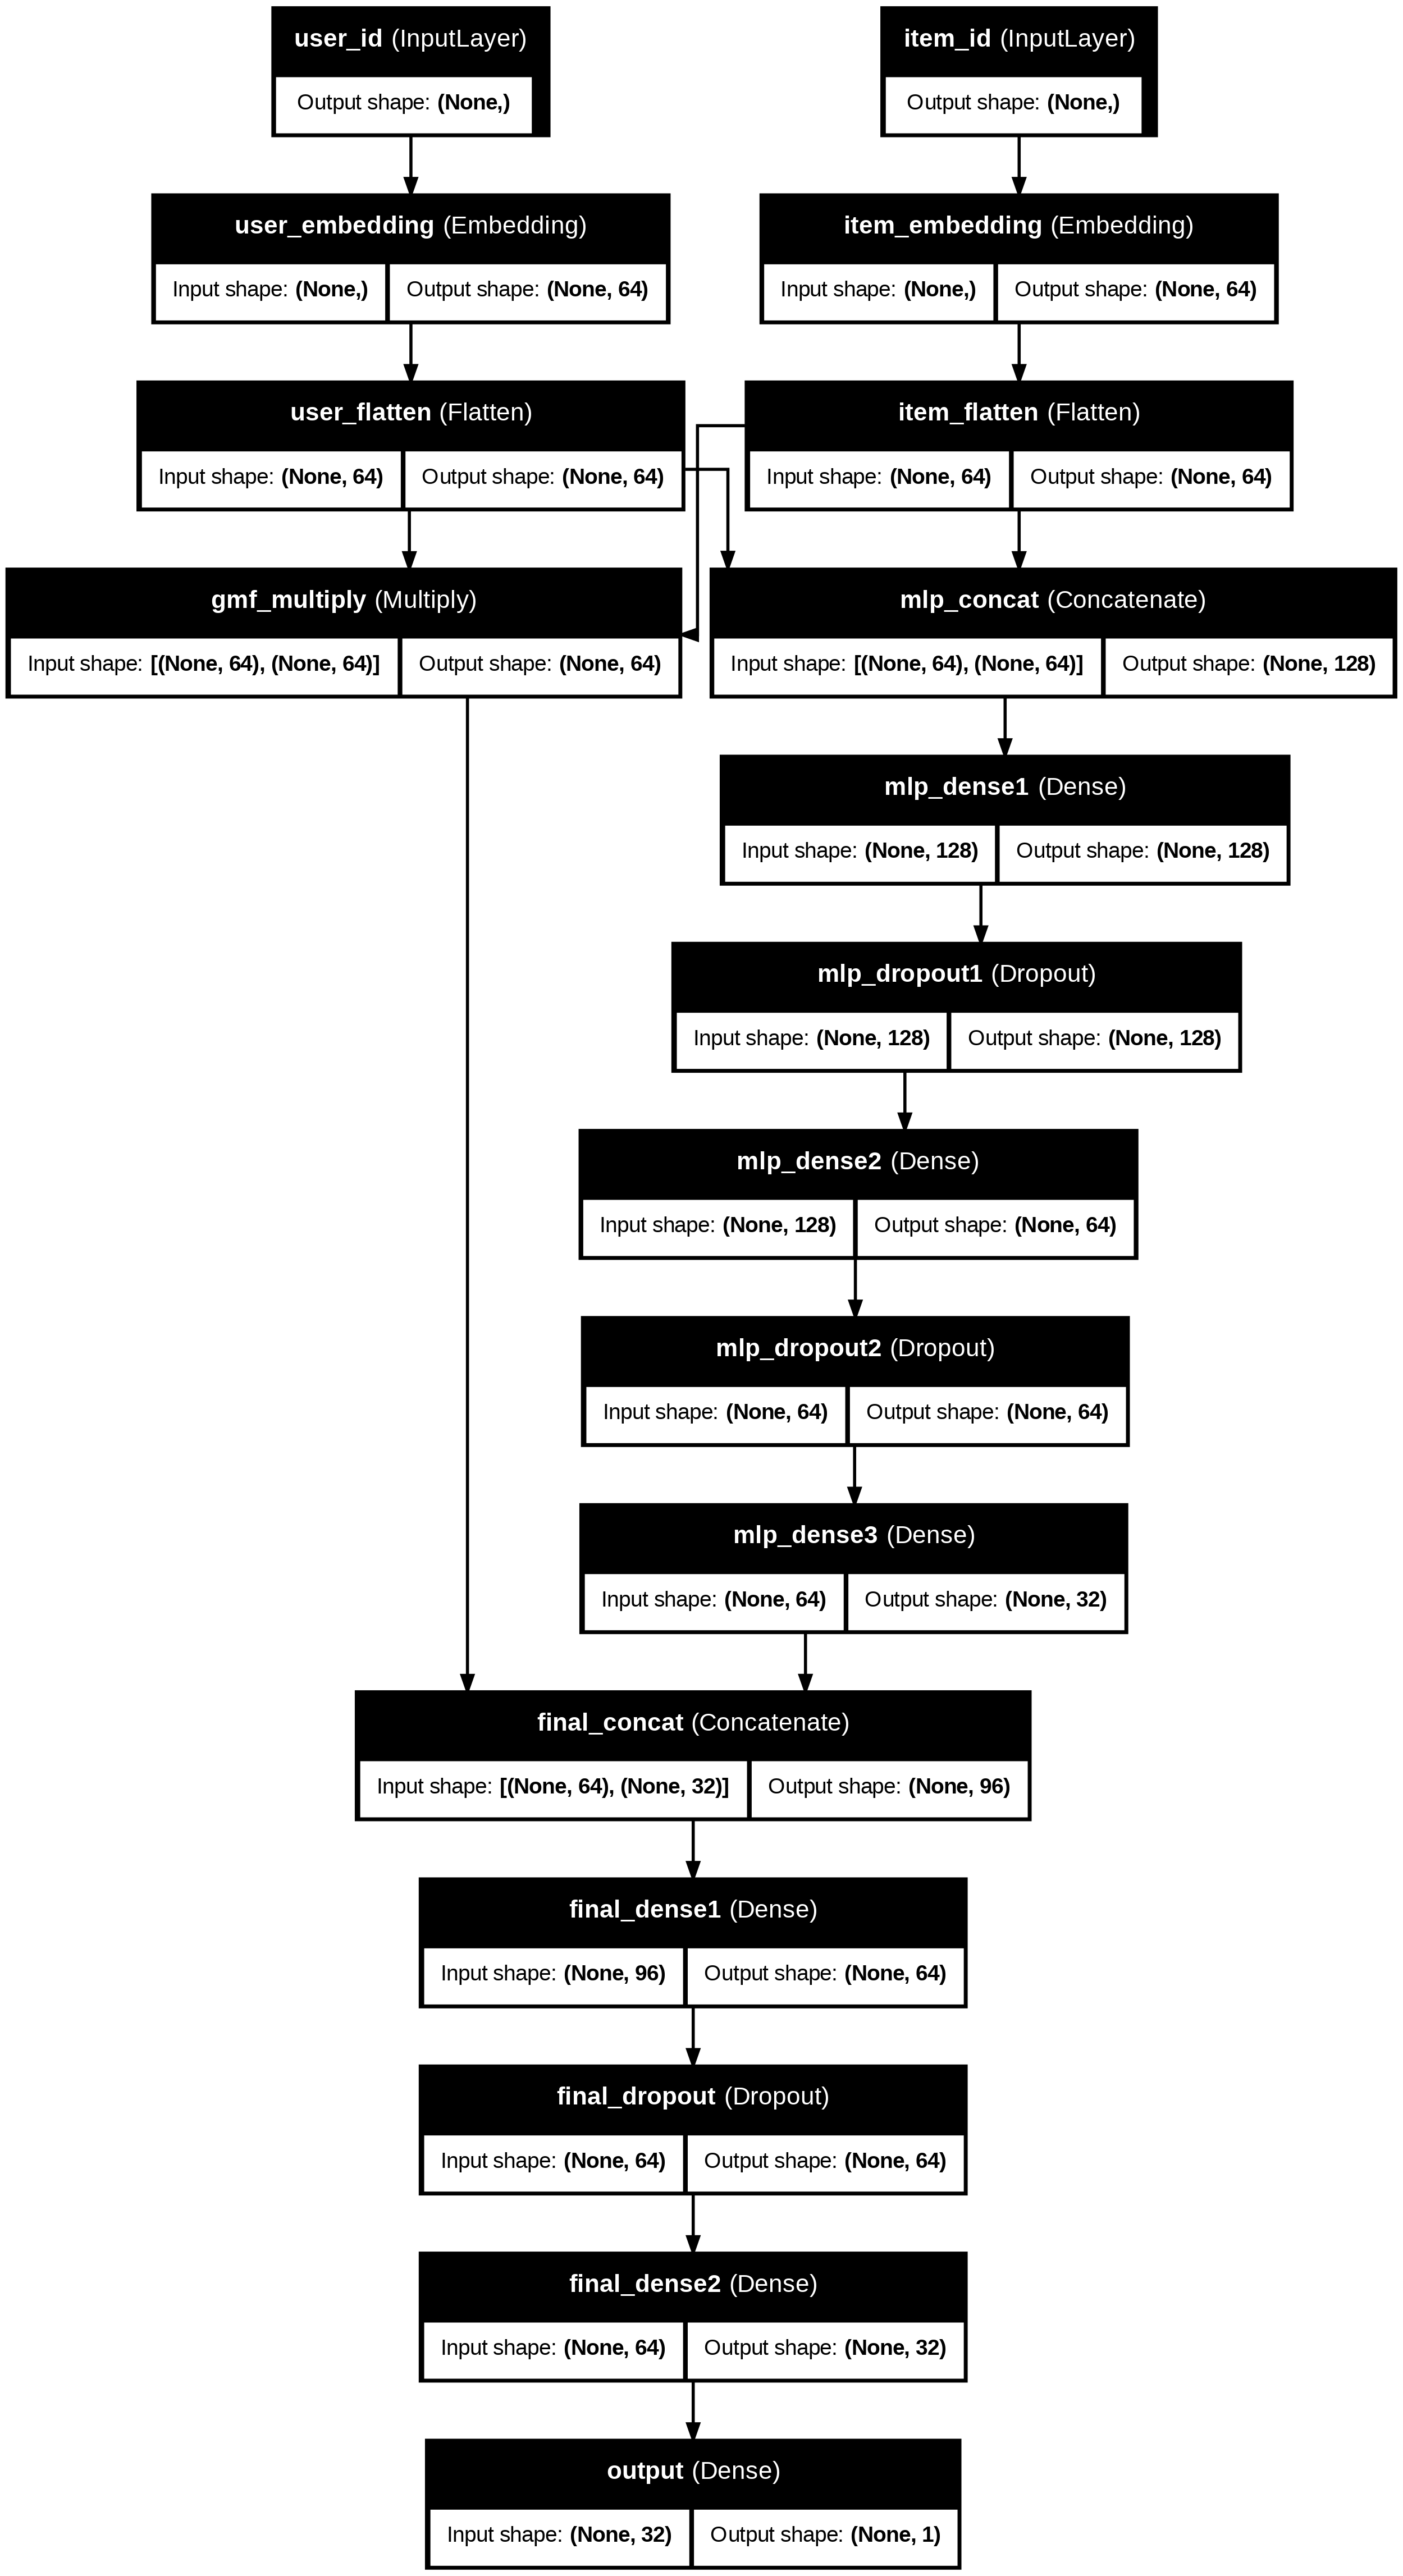

In [7]:
print("\n" + "="*50)
print("MODEL BUILDING")
print("="*50)

class CollaborativeFilteringModel:
    def __init__(self, n_users, n_items, embedding_dim=64, reg_lambda=0.01):
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.reg_lambda = reg_lambda
        self.model = None
        self.history = None

    def build_model(self):
        # User input
        user_input = layers.Input(shape=(), name='user_id')
        user_embedding = layers.Embedding(
            input_dim=self.n_users,
            output_dim=self.embedding_dim,
            embeddings_regularizer=regularizers.l2(self.reg_lambda),
            name='user_embedding'
        )(user_input)
        user_vec = layers.Flatten(name='user_flatten')(user_embedding)

        # Item input
        item_input = layers.Input(shape=(), name='item_id')
        item_embedding = layers.Embedding(
            input_dim=self.n_items,
            output_dim=self.embedding_dim,
            embeddings_regularizer=regularizers.l2(self.reg_lambda),
            name='item_embedding'
        )(item_input)
        item_vec = layers.Flatten(name='item_flatten')(item_embedding)

        # Neural Collaborative Filtering approach
        # 1. Generalized Matrix Factorization (GMF)
        gmf_vector = layers.Multiply(name='gmf_multiply')([user_vec, item_vec])

        # 2. Multi-Layer Perceptron (MLP)
        mlp_vector = layers.Concatenate(name='mlp_concat')([user_vec, item_vec])
        mlp_vector = layers.Dense(128, activation='relu', name='mlp_dense1')(mlp_vector)
        mlp_vector = layers.Dropout(0.3, name='mlp_dropout1')(mlp_vector)
        mlp_vector = layers.Dense(64, activation='relu', name='mlp_dense2')(mlp_vector)
        mlp_vector = layers.Dropout(0.3, name='mlp_dropout2')(mlp_vector)
        mlp_vector = layers.Dense(32, activation='relu', name='mlp_dense3')(mlp_vector)

        # 3. Combine GMF and MLP
        concat_vector = layers.Concatenate(name='final_concat')([gmf_vector, mlp_vector])

        # Final prediction layers
        dense1 = layers.Dense(64, activation='relu', name='final_dense1')(concat_vector)
        dense1 = layers.Dropout(0.2, name='final_dropout')(dense1)
        dense2 = layers.Dense(32, activation='relu', name='final_dense2')(dense1)
        output = layers.Dense(1, activation='sigmoid', name='output')(dense2)

        # Create model
        self.model = Model(inputs=[user_input, item_input], outputs=output, name='CollaborativeFiltering')

        # Compile model
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return self.model

    def add_transfer_learning_features(self):
        """Add transfer learning capabilities using pre-trained embeddings"""
        # Freeze initial layers for transfer learning approach
        for layer in self.model.layers[:4]:  # Freeze embedding layers initially
            layer.trainable = False

        print("Added transfer learning: Embedding layers frozen for initial training")

    def unfreeze_layers(self):
        """Unfreeze layers for fine-tuning"""
        for layer in self.model.layers:
            layer.trainable = True

        # Recompile with lower learning rate for fine-tuning
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        print("All layers unfrozen for fine-tuning with reduced learning rate")

# Build model
model_cf = CollaborativeFilteringModel(n_users, n_items, embedding_dim=64)
model = model_cf.build_model()

print("Model Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [8]:
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Prepare training data
X_train = [train_data['user_encoded'].values, train_data['item_encoded'].values]
y_train = train_data['rating_normalized'].values

X_val = [val_data['user_encoded'].values, val_data['item_encoded'].values]
y_val = val_data['rating_normalized'].values

X_test = [test_data['user_encoded'].values, test_data['item_encoded'].values]
y_test = test_data['rating_normalized'].values

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Transfer Learning Training Strategy
print("Starting Transfer Learning Training...")

# Phase 1: Train with frozen embeddings
model_cf.add_transfer_learning_features()
history1 = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Phase 2: Fine-tuning with unfrozen layers
print("\nStarting Fine-tuning Phase...")
model_cf.unfreeze_layers()
history2 = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Combine histories
combined_history = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'mae': history1.history['mae'] + history2.history['mae'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_mae': history1.history['val_mae'] + history2.history['val_mae']
}


MODEL TRAINING
Starting Transfer Learning Training...
Added transfer learning: Embedding layers frozen for initial training
Epoch 1/20
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1264 - mae: 0.3030 - mse: 0.1264

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1263 - mae: 0.3029 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3000 - val_mse: 0.1252 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1263 - mae: 0.3027 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.2999 - val_mse: 0.1252 - learning_rate: 0.0010
Epoch 3/20
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1264 - mae: 0.3027 - mse: 0.1264

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1263 - mae: 0.3026 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3002 - val_mse: 0.1252 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1263 - mae: 0.3027 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3004 - val_mse: 0.1252 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1262 - mae: 0.3030 - mse: 0.1262 - val_loss: 0.1253 - val_mae: 0.3009 - val_mse: 0.1253 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1261 - mae: 0.3031 - mse: 0.1261 - val_loss: 0.1256 - val_mae: 0.3025 - val_mse: 0.1256 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1258 - mae: 0.3036 - mse: 0.1258 - val_loss: 0.1258 - val_mae: 0.3034 - val_mse: 0.1258 - learning_rate: 5.0000e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1251 - mae: 0.3034 - mse: 0.1251 - val_loss: 0.1262 - val_mae: 0.3048 - val_mse: 0.

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1263 - mae: 0.3025 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 1.0000e-04
Epoch 11/30
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1264 - mae: 0.3026 - mse: 0.1263

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3025 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 1.0000e-04
Epoch 12/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1263 - mae: 0.3025 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 1.0000e-04
Epoch 13/30
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1264 - mae: 0.3026 - mse: 0.1263

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3025 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 1.0000e-04
Epoch 14/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1264 - mae: 0.3024 - mse: 0.1263

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1251 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 5.0000e-05
Epoch 15/30
115/120 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1264 - mae: 0.3025 - mse: 0.1264

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1251 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 5.0000e-05
Epoch 16/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1251 - val_mae: 0.3006 - val_mse: 0.1251 - learning_rate: 5.0000e-05
Epoch 17/30
114/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1264 - mae: 0.3025 - mse: 0.1264

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1251 - val_mae: 0.3006 - val_mse: 0.1251 - learning_rate: 5.0000e-05
Epoch 18/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 5.0000e-05
Epoch 19/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 2.5000e-05
Epoch 20/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3023 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3005 - val_mse: 0.1251 - learning_rate: 2.5000e-05
Epoch 21/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1252 - val_mae: 0.3006 - val_mse: 0.1251 - learning_rate: 2.5000e-05
Epoch 22/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1263 - mae: 0.3024 - mse: 0.1263 - val_loss: 0.1252 - 


MODEL EVALUATION


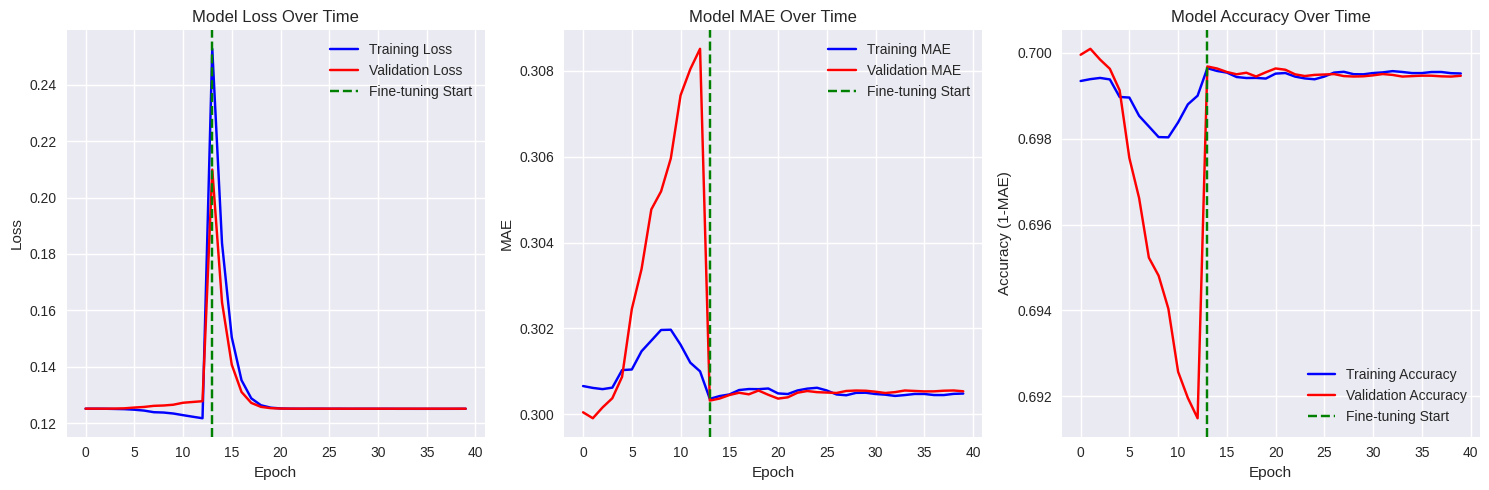

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Set Evaluation:
MSE: 2.0019
RMSE: 1.4149
MAE: 1.2020


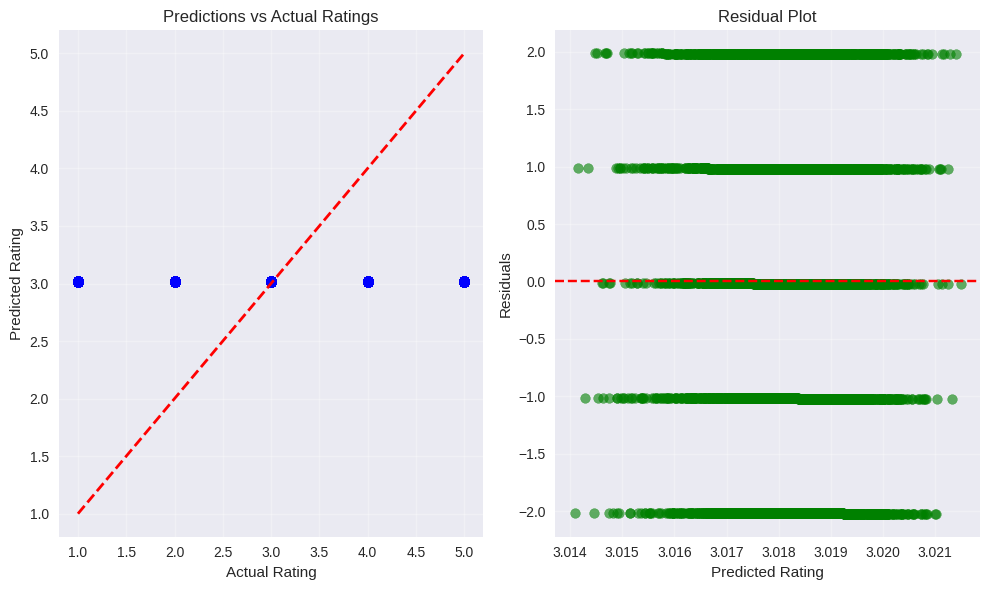


Top-10 Recommendations for user001:
No recommendations available (user not found or all items already rated).

Top-N Evaluation (K=10):
Precision@10: nan
Recall@10: 0.0000


In [11]:
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Training history visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(combined_history['loss'], label='Training Loss', color='blue')
plt.plot(combined_history['val_loss'], label='Validation Loss', color='red')
plt.axvline(x=len(history1.history['loss']), color='green', linestyle='--', label='Fine-tuning Start')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(combined_history['mae'], label='Training MAE', color='blue')
plt.plot(combined_history['val_mae'], label='Validation MAE', color='red')
plt.axvline(x=len(history1.history['mae']), color='green', linestyle='--', label='Fine-tuning Start')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
train_acc = 1 - np.array(combined_history['mae'])
val_acc = 1 - np.array(combined_history['val_mae'])
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.axvline(x=len(history1.history['mae']), color='green', linestyle='--', label='Fine-tuning Start')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (1-MAE)')
plt.legend()

plt.tight_layout()
plt.show()

# Test set evaluation
test_predictions = model.predict(X_test)
test_predictions_denorm = test_predictions.flatten() * (max_rating - min_rating) + min_rating
test_actual_denorm = test_data['rating'].values

# Calculate metrics
mse = mean_squared_error(test_actual_denorm, test_predictions_denorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual_denorm, test_predictions_denorm)

print(f"\nTest Set Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Prediction vs Actual scatter plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_actual_denorm, test_predictions_denorm, alpha=0.6, color='blue')
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predictions vs Actual Ratings')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = test_actual_denorm - test_predictions_denorm
plt.scatter(test_predictions_denorm, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Top-N Recommendation Evaluation
def get_top_n_recommendations(model, user_id, n=10, exclude_rated=True):
    """Get top N recommendations for a user"""
    if isinstance(user_id, str):
        if user_id not in user_to_encoded:
            return []
        user_encoded = user_to_encoded[user_id]
    else:
        user_encoded = user_id

    # Get all items
    all_items = np.arange(n_items)
    user_array = np.full(n_items, user_encoded)

    if exclude_rated:
        rated_items = df[df['user_encoded'] == user_encoded]['item_encoded'].values
        mask = ~np.isin(all_items, rated_items)
        all_items = all_items[mask]
        user_array = user_array[mask]

    # Handle empty prediction case
    if len(user_array) == 0:
        return []

    # Predict ratings
    predictions = model.predict([user_array, all_items], verbose=0)
    predictions_denorm = predictions.flatten() * (max_rating - min_rating) + min_rating

    # Get top N
    top_indices = np.argsort(predictions_denorm)[::-1][:n]
    top_items = all_items[top_indices]
    top_scores = predictions_denorm[top_indices]

    recommendations = []
    for item_encoded, score in zip(top_items, top_scores):
        item_name = encoded_to_item[item_encoded]
        recommendations.append((item_name, score))

    return recommendations

# Test Top-N recommendations
print(f"\nTop-10 Recommendations for user001:")
recommendations = get_top_n_recommendations(model, 'user001', n=10)
if not recommendations:
    print("No recommendations available (user not found or all items already rated).")
else:
    for i, (item, score) in enumerate(recommendations, 1):
        print(f"{i:2d}. {item:<40} (Score: {score:.2f})")

# Calculate Top-N metrics (Precision@K, Recall@K)
def calculate_topn_metrics(model, test_data, k=10, threshold=4.0):
    """Calculate Precision@K and Recall@K"""
    precisions = []
    recalls = []

    user_groups = test_data.groupby('user_encoded')

    for user_encoded, group in user_groups:
        actual_items = set(group[group['rating'] >= threshold]['item_encoded'].values)
        if len(actual_items) == 0:
            continue

        recs = get_top_n_recommendations(model, user_encoded, n=k, exclude_rated=False)
        recommended_items = set([item_to_encoded[item] for item, score in recs if score >= threshold])

        if len(recommended_items) > 0:
            precision = len(actual_items.intersection(recommended_items)) / len(recommended_items)
            precisions.append(precision)

        recall = len(actual_items.intersection(recommended_items)) / len(actual_items)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

precision_10, recall_10 = calculate_topn_metrics(model, test_data, k=10)
print(f"\nTop-N Evaluation (K=10):")
print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")
if precision_10 + recall_10 > 0:
    f1_score = 2 * (precision_10 * recall_10) / (precision_10 + recall_10)
    print(f"F1-Score@10: {f1_score:.4f}")


In [12]:
print("\n" + "="*50)
print("INFERENCE FUNCTIONS")
print("="*50)

class RecommendationSystem:
    def __init__(self, model, user_encoder, item_encoder, min_rating, max_rating):
        self.model = model
        self.user_encoder = user_encoder
        self.item_encoder = item_encoder
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.user_to_encoded = dict(zip(user_encoder.classes_,
                                      user_encoder.transform(user_encoder.classes_)))
        self.item_to_encoded = dict(zip(item_encoder.classes_,
                                      item_encoder.transform(item_encoder.classes_)))
        self.encoded_to_user = {v: k for k, v in self.user_to_encoded.items()}
        self.encoded_to_item = {v: k for k, v in self.item_to_encoded.items()}

    def predict_rating(self, user_id, item_id):
        if user_id not in self.user_to_encoded or item_id not in self.item_to_encoded:
            raise ValueError(f"User or item not found: {user_id}, {item_id}")

        user_encoded = self.user_to_encoded[user_id]
        item_encoded = self.item_to_encoded[item_id]

        # Pastikan berbentuk array berdimensi batch
        user_input = np.array([user_encoded])
        item_input = np.array([item_encoded])

        pred = self.model.predict([user_input, item_input], verbose=0)
        return pred[0][0]

    def get_recommendations(self, user_id, n=10, exclude_rated=True):
        """Get top N recommendations for a user"""
        if user_id not in self.user_to_encoded:
            return []

        return get_top_n_recommendations(self.model, user_id, n, exclude_rated)

    def get_similar_items(self, item_id, n=10):
        """Get similar items based on item embeddings"""
        if item_id not in self.item_to_encoded:
            return []

        # Get item embeddings
        item_embedding_layer = self.model.get_layer('item_embedding')
        item_embeddings = item_embedding_layer.get_weights()[0]

        item_encoded = self.item_to_encoded[item_id]
        target_embedding = item_embeddings[item_encoded]

        # Calculate cosine similarity
        similarities = []
        for i, embedding in enumerate(item_embeddings):
            if i != item_encoded:
                similarity = np.dot(target_embedding, embedding) / (
                    np.linalg.norm(target_embedding) * np.linalg.norm(embedding)
                )
                similarities.append((i, similarity))

        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)

        # Return top N similar items
        similar_items = []
        for item_encoded, similarity in similarities[:n]:
            item_name = self.encoded_to_item[item_encoded]
            similar_items.append((item_name, similarity))

        return similar_items

# Create recommendation system instance
rec_system = RecommendationSystem(model, user_encoder, item_encoder, min_rating, max_rating)

# Test inference functions
print("Testing Inference Functions:")

# Test rating prediction
test_user = 'user001'
test_item = 'Wisata Alam Datuk'
predicted_rating = rec_system.predict_rating(test_user, test_item)
print(f"\nPredicted rating for {test_user} - {test_item}: {predicted_rating:.2f}")

# Test recommendations
print(f"\nTop-5 Recommendations for {test_user}:")
recommendations = rec_system.get_recommendations(test_user, n=5)
for i, (item, score) in enumerate(recommendations, 1):
    print(f"{i}. {item} (Score: {score:.2f})")

# Test similar items
print(f"\nItems similar to '{test_item}':")
similar_items = rec_system.get_similar_items(test_item, n=5)
for i, (item, similarity) in enumerate(similar_items, 1):
    print(f"{i}. {item} (Similarity: {similarity:.3f})")


INFERENCE FUNCTIONS
Testing Inference Functions:

Predicted rating for user001 - Wisata Alam Datuk: 0.50

Top-5 Recommendations for user001:

Items similar to 'Wisata Alam Datuk':
1. Edukasi Digital - Saparunesia Trip (Similarity: 0.354)
2. Tempat Edukasi SD - Saparunesia Trip (Similarity: 0.334)
3. Danau Lau Kawar (Similarity: 0.329)
4. Pajak Gotong Royong (Similarity: 0.318)
5. Istana Raja Sisingamangaraja (Similarity: 0.314)


In [14]:
print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

# Create models directory
os.makedirs('models', exist_ok=True)

# 1. Save as Keras/H5 format
model.save('models/collaborative_filtering_model.h5')
print("✓ Model saved as Keras H5 format")

# 2. Save as SavedModel format (for TensorFlow Serving)
model.export('models/collaborative_filtering_model_savedmodel')
print("✓ Model saved as SavedModel format")

# 3. Save as TensorFlow.js format
tfjs.converters.save_keras_model(model, 'models/collaborative_filtering_model_tfjs')
print("✓ Model saved as TensorFlow.js format")

# 4. Save preprocessing objects and metadata as pickle
model_artifacts = {
    'user_encoder': user_encoder,
    'item_encoder': item_encoder,
    'user_to_encoded': user_to_encoded,
    'item_to_encoded': item_to_encoded,
    'encoded_to_user': encoded_to_user,
    'encoded_to_item': encoded_to_item,
    'min_rating': min_rating,
    'max_rating': max_rating,
    'n_users': n_users,
    'n_items': n_items,
    'model_metrics': {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'precision_10': precision_10,
        'recall_10': recall_10
    }
}

with open('models/model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)
print("✓ Model artifacts saved as pickle")

# 5. Save recommendation system instance
with open('models/recommendation_system.pkl', 'wb') as f:
    pickle.dump(rec_system, f)
print("✓ Recommendation system saved as pickle")

# Save training history
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)
print("✓ Training history saved")


SAVING MODEL
✓ Model saved as Keras H5 format
Saved artifact at 'models/collaborative_filtering_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None,), dtype=tf.float32, name='user_id'), TensorSpec(shape=(None,), dtype=tf.float32, name='item_id')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140173773365968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773364048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773365776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773367504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773368656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773369424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773369616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773370576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140173773368272: TensorSpe

✓ Model saved as SavedModel format
failed to lookup keras version from the file,
    this is likely a weight only file
✓ Model saved as TensorFlow.js format
✓ Model artifacts saved as pickle
✓ Recommendation system saved as pickle
✓ Training history saved


In [15]:
import shutil

shutil.make_archive('collaborative_filtering_model', 'zip', 'models')

'/content/collaborative_filtering_model.zip'

In [16]:
from google.colab import files

files.download('collaborative_filtering_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>